In [75]:

from sklearn.model_selection import train_test_split  
from sklearn.metrics import accuracy_score  
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import pandas as pd
import numpy as np
import toad
import seaborn as sns


In [176]:
# 定义一个计算ks值的曲线
from matplotlib import font_manager
font_path = 'C:/Windows/Fonts/msyh.ttc'  # Windows系统
my_font = font_manager.FontProperties(fname=font_path).get_name()
def plot_ks(y_true, y_pred, name):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    ks = (tpr - fpr).max()
    plt.plot(thresholds[1:], tpr[1:], label='TPR')
    plt.plot(thresholds[1:], fpr[1:], label='FPR')
    plt.plot(thresholds[1:], (tpr - fpr)[1:], label='KS')
    plt.axvline(x=thresholds[(tpr - fpr).argmax() + 1], color='r', linestyle='--')
    plt.title(f'{name}KS曲线 (KS = {ks:.4f})', fontname=my_font)
    plt.legend()
    plt.show()

In [96]:
def plot_roc(y_true, y_pred_proba, name, figsize=(8, 6)):
    """
    绘制ROC曲线并返回AUC值
    参数：
        y_true: 真实标签，数组或Series，值为0或1
        y_pred_proba: 预测的正类概率，数组
        figsize: 图像尺寸
    返回：
        auc_value: 计算得到的AUC值
    """
    # 计算假正率和真正率
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    # 计算AUC
    auc_value = auc(fpr, tpr)
    
    # 绘制ROC曲线
    plt.figure(figsize=figsize)
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {auc_value:.4f}')
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{name}ROC曲线', fontname=my_font)
    plt.legend(loc='lower right')
    plt.show()
    
    return auc_value

# 1.使用筛选的变量建模

## 1.1变量筛选

In [2]:
data = pd.read_csv('final_data.csv')

NameError: name 'pd' is not defined

In [ ]:
data.shape

(729534, 49)

In [ ]:
skip_col = ['isDefault']

In [ ]:
data.drop(columns=['xgb','lgb','NN'], inplace=True)

In [ ]:
import toad
train_selected, dropped = toad.selection.select(data ,target = 'isDefault', empty = 0.5, iv = 0.01, corr = 0.9, return_drop=True)

In [ ]:
train_selected1 = train_selected.copy()

In [ ]:
dropped

{'empty': array([], dtype=float64),
 'iv': array(['Unnamed: 0', 'postCode', 'regionCode', 'delinquency_2years',
        'openAcc', 'pubRec', 'pubRecBankruptcies', 'revolBal', 'totalAcc',
        'initialListStatus', 'applicationType', 'policyCode', 'n0', 'n1',
        'n4', 'n5', 'n6', 'n7', 'n8', 'n10', 'n11', 'n12', 'n13'],
       dtype=object),
 'corr': array(['n9', 'interestRate', 'n3', 'installment', 'ficoRangeHigh',
        'grade'], dtype=object)}

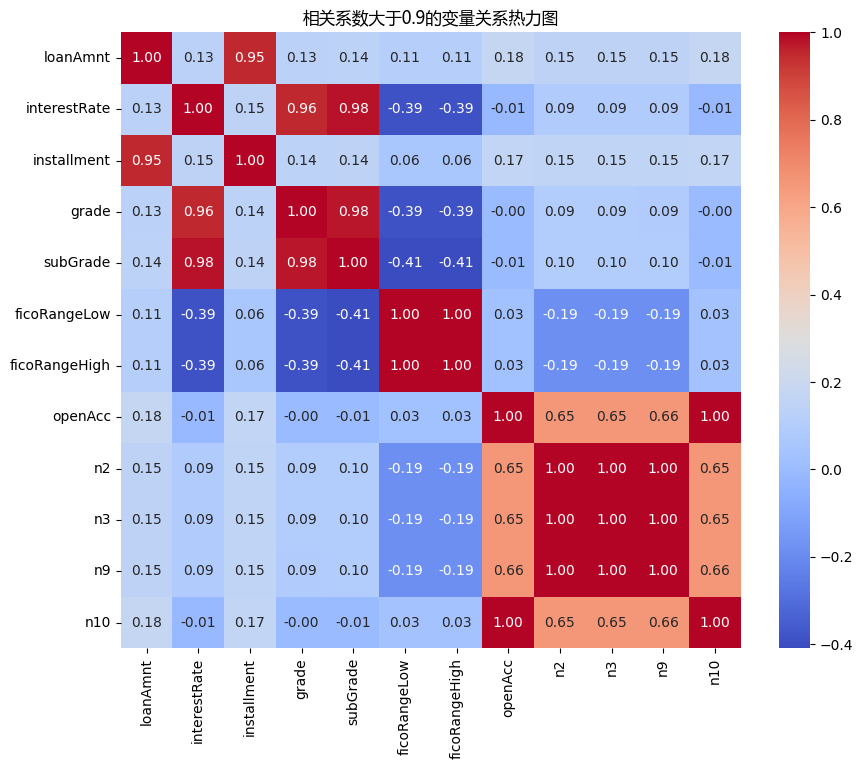

In [ ]:

corr_matrix = data.corr()

# 只保留相关系数绝对值大于0.9的变量
# 将对角线元素（1.0）设为False，避免自己与自己比较
mask = np.abs(corr_matrix) > 0.9
np.fill_diagonal(mask.values, False)

# 筛选出相关度大于0.9的变量名
vars_to_show = corr_matrix.columns[mask.any()]

# 提取这些变量的相关性子矩阵
sub_corr = corr_matrix.loc[vars_to_show, vars_to_show]

# 绘制热力图
plt.figure(figsize=(10,8))
sns.heatmap(sub_corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('相关系数大于0.9的变量关系热力图', fontname=my_font)
plt.show()

In [ ]:
# initialise
c = toad.transform.Combiner()

# 使用特征筛选后的数据进行训练：使用稳定的卡方分箱，规定每箱至少有5%数据, 空值将自动被归到最佳箱。
c.fit(train_selected, y = 'isDefault', method = 'dt', min_samples = 0.05) #empty_separate = False

In [ ]:
isDefault = train_selected[['isDefault']]

In [ ]:
final_data

,loanAmnt,term,subGrade,employmentTitle,homeOwnership,annualIncome,verificationStatus,issueDate,purpose,dti,ficoRangeLow,revolUtil,earliesCreditLine,title,n2,n14,isDefault
0,35000.0,5,22,320.0,2,110000.0,2,130,1,17.05,730.0,48.9,285,1.0,2.0,2.0,1
2,12000.0,5,18,31698.0,0,74000.0,2,115,0,22.77,675.0,51.8,228,0.0,3.0,4.0,0
3,11000.0,3,4,46854.0,1,118000.0,1,117,4,17.21,685.0,52.6,312,4.0,6.0,1.0,0
4,3000.0,3,12,54.0,1,29000.0,2,110,10,32.16,690.0,32.0,573,11.0,7.0,4.0,0
5,11000.0,3,5,51727.0,0,39000.0,2,97,9,17.14,730.0,31.1,322,10.0,2.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799995,25000.0,3,14,2659.0,1,72000.0,0,106,0,19.03,710.0,46.4,165,0.0,10.0,3.0,0
799996,17000.0,3,4,29205.0,0,99000.0,2,145,4,15.72,720.0,98.4,432,33369.0,2.0,0.0,0
799997,6000.0,3,13,2582.0,1,65000.0,2,115,0,12.11,670.0,51.9,274,0.0,4.0,4.0,1
799998,19200.0,3,4,151.0,0,96000.0,2,123,4,29.25,675.0,61.3,376,4.0,8.0,5.0,0


In [ ]:
data = pd.concat([data, train_selected['isDefault']])

In [ ]:
data.drop(columns='isDefault', inplace=True)

In [ ]:
data= pd.concat([data, train_selected[['isDefault']]], axis=1)

In [ ]:
train_selected

,loanAmnt,term,subGrade,employmentTitle,homeOwnership,annualIncome,verificationStatus,issueDate,isDefault,purpose,dti,ficoRangeLow,revolUtil,earliesCreditLine,title,n2,n14
0,35000.0,5,22,320.0,2,110000.0,2,130,1,1,17.05,730.0,48.9,285,1.0,2.0,2.0
1,12000.0,5,18,31698.0,0,74000.0,2,115,0,0,22.77,675.0,51.8,228,0.0,3.0,4.0
2,11000.0,3,4,46854.0,1,118000.0,1,117,0,4,17.21,685.0,52.6,312,4.0,6.0,1.0
3,3000.0,3,12,54.0,1,29000.0,2,110,0,10,32.16,690.0,32.0,573,11.0,7.0,4.0
4,11000.0,3,5,51727.0,0,39000.0,2,97,0,9,17.14,730.0,31.1,322,10.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729529,25000.0,3,14,2659.0,1,72000.0,0,106,0,0,19.03,710.0,46.4,165,0.0,10.0,3.0
729530,17000.0,3,4,29205.0,0,99000.0,2,145,0,4,15.72,720.0,98.4,432,33369.0,2.0,0.0
729531,6000.0,3,13,2582.0,1,65000.0,2,115,1,0,12.11,670.0,51.9,274,0.0,4.0,4.0
729532,19200.0,3,4,151.0,0,96000.0,2,123,0,4,29.25,675.0,61.3,376,4.0,8.0,5.0


In [ ]:
#cat_col = ['grade', 'subGrade', 'employmentLength','isDefault']
# 选择类别变量列  
#train_cat = train_selected[cat_col]  # 提取类别变量 

In [ ]:
# woe分箱
transer = toad.transform.WOETransformer()
train_woe = transer.fit_transform(c.transform(train_selected), train_selected['isDefault'], exclude=['isDefault'])

In [ ]:
final_data = train_selected.copy()

In [ ]:
final_data = data.drop(columns=['xgb','lgb','NN'])

In [ ]:
final_data

,loanAmnt,term,subGrade,employmentTitle,homeOwnership,annualIncome,verificationStatus,issueDate,purpose,dti,ficoRangeLow,revolUtil,earliesCreditLine,title,n2,n14,isDefault
0,35000.0,5,22,320.0,2,110000.0,2,130,1,17.05,730.0,48.9,285,1.0,2.0,2.0,1
1,12000.0,5,18,31698.0,0,74000.0,2,115,0,22.77,675.0,51.8,228,0.0,3.0,4.0,0
2,11000.0,3,4,46854.0,1,118000.0,1,117,4,17.21,685.0,52.6,312,4.0,6.0,1.0,0
3,3000.0,3,12,54.0,1,29000.0,2,110,10,32.16,690.0,32.0,573,11.0,7.0,4.0,0
4,11000.0,3,5,51727.0,0,39000.0,2,97,9,17.14,730.0,31.1,322,10.0,2.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729529,25000.0,3,14,2659.0,1,72000.0,0,106,0,19.03,710.0,46.4,165,0.0,10.0,3.0,0
729530,17000.0,3,4,29205.0,0,99000.0,2,145,4,15.72,720.0,98.4,432,33369.0,2.0,0.0,0
729531,6000.0,3,13,2582.0,1,65000.0,2,115,0,12.11,670.0,51.9,274,0.0,4.0,4.0,1
729532,19200.0,3,4,151.0,0,96000.0,2,123,4,29.25,675.0,61.3,376,4.0,8.0,5.0,0


In [ ]:
data

,loanAmnt,term,subGrade,employmentTitle,homeOwnership,annualIncome,verificationStatus,issueDate,purpose,dti,ficoRangeLow,revolUtil,earliesCreditLine,title,n2,n14,isDefault
0,35000.0,5,22,320.0,2,110000.0,2,130,1,17.05,730.0,48.9,285,1.0,2.0,2.0,1
2,12000.0,5,18,31698.0,0,74000.0,2,115,0,22.77,675.0,51.8,228,0.0,3.0,4.0,0
3,11000.0,3,4,46854.0,1,118000.0,1,117,4,17.21,685.0,52.6,312,4.0,6.0,1.0,0
4,3000.0,3,12,54.0,1,29000.0,2,110,10,32.16,690.0,32.0,573,11.0,7.0,4.0,0
5,11000.0,3,5,51727.0,0,39000.0,2,97,9,17.14,730.0,31.1,322,10.0,2.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799995,25000.0,3,14,2659.0,1,72000.0,0,106,0,19.03,710.0,46.4,165,0.0,10.0,3.0,0
799996,17000.0,3,4,29205.0,0,99000.0,2,145,4,15.72,720.0,98.4,432,33369.0,2.0,0.0,0
799997,6000.0,3,13,2582.0,1,65000.0,2,115,0,12.11,670.0,51.9,274,0.0,4.0,4.0,1
799998,19200.0,3,4,151.0,0,96000.0,2,123,4,29.25,675.0,61.3,376,4.0,8.0,5.0,0


## 1.2拆分后的数据使用xgb建模

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score , roc_auc_score

In [ ]:
import pandas as pd  
from sklearn.model_selection import train_test_split  
from sklearn.preprocessing import StandardScaler 
# 选择特征和目标变量  
X = final_data.drop(columns=['isDefault'])  # 假设目标变量为 'isDefault'  
y = final_data['isDefault']  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#scaler = StandardScaler()  
#X_train = scaler.fit_transform(X_train)  
#X_test = scaler.transform(X_test)  #划分数据集  
 


In [ ]:
import xgboost as xgb  
from sklearn.metrics import accuracy_score  

# 初始化模型  
xgb_model = xgb.XGBClassifier(
    use_label_encoder=False,  
    eval_metric='logloss',  
    max_depth=6,  
    learning_rate=0.01,  
    n_estimators=1000,  
    subsample=0.8,  
    colsample_bytree=0.8,  
    gamma=0,  
    random_state=42  
)  
# 训练模型  
xgb_model.fit(X_train, y_train)  

# 预测  
y_pred_xgb = xgb_model.predict(X_test)  
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)  
y_pred_xgb_pro = xgb_model.predict_proba(X_test)[:,1]
print(f'XGBoost Accuracy: {accuracy_xgb:.4f}')  

c:\Users\谭艺星\OneDrive\桌面\毕业设计\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:50:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 0.8054


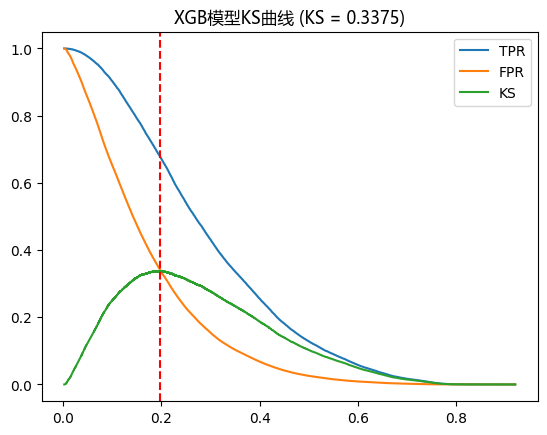

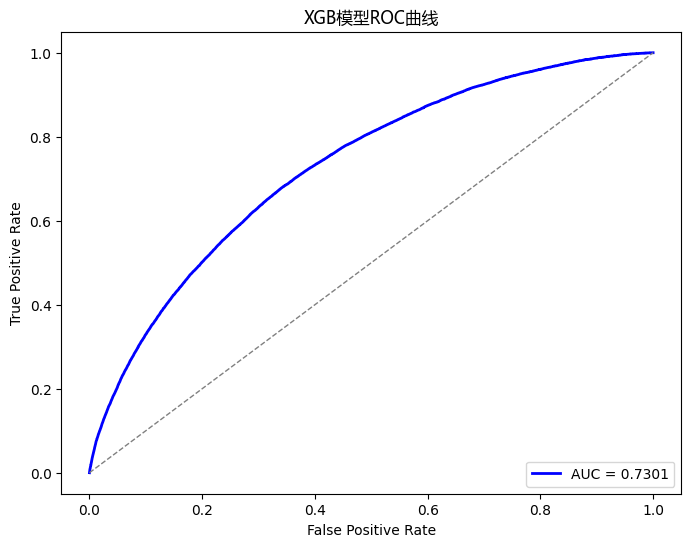

(None, 0.7300724479789944)

In [ ]:
plot_ks(y_test, y_pred_xgb_pro,'XGB模型'), plot_roc(y_test, y_pred_xgb_pro, 'XGB模型')

In [ ]:
#定义一个计算ks值的函数 
def report(y_test, y_pred_pro):
    # 预测概率（假设 y_pred_xgb_pro 是模型生成的预测概率）  
    # y_pred_xgb_pro 是模型对测试集的预测概率  
    # y_test 是实际的测试标签  

    # 将预测概率和真实标签合并为 DataFrame  
    results = pd.DataFrame({'actual': y_test, 'predicted_prob': y_pred_pro})  

    # 按预测概率降序排列  
    results = results.sort_values(by='predicted_prob', ascending=False)  

    # 计算正类和负类的累积占比（累积分布）  
    results['cum_positive'] = (results['actual'] == 1).cumsum() / (results['actual'] == 1).sum()  
    results['cum_negative'] = (results['actual'] == 0).cumsum() / (results['actual'] == 0).sum()  

    # 计算 KS 值  
    results['KS'] = results['cum_positive'] - results['cum_negative']  
    ks_value = results['KS'].max()  
    
    #计算auc值
    auc = roc_auc_score(y_test, y_pred_pro)
    # 输出 KS 值  
    return (f'KS Value: {ks_value:.4f}; AUC: {auc}')  

## 1.3拆分后的数据使用lgbm建模

In [ ]:
import lightgbm as lgb  

# 创建数据集  
lgb_train = lgb.Dataset(X_train, label=y_train)  
lgb_test = lgb.Dataset(X_test, label=y_test, reference=lgb_train)  

# 设置参数  
params = {  
    'objective': 'binary',  
    'metric': 'binary_logloss',  
    'boosting_type': 'gbdt',  
    'num_leaves': 31,  
    'learning_rate': 0.01,  
    'feature_fraction': 0.8,  
    'bagging_fraction': 0.8,  
    'bagging_freq': 5,  
    'verbose': -1 
}  

# 训练模型  
lgb_model = lgb.train(params, lgb_train, valid_sets=lgb_test, num_boost_round=1000)

# 预测  
y_pred_lgb_pro = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)
y_pred_lgb = [1 if score >= 0.5 else 0 for score in y_pred_lgb_pro]  

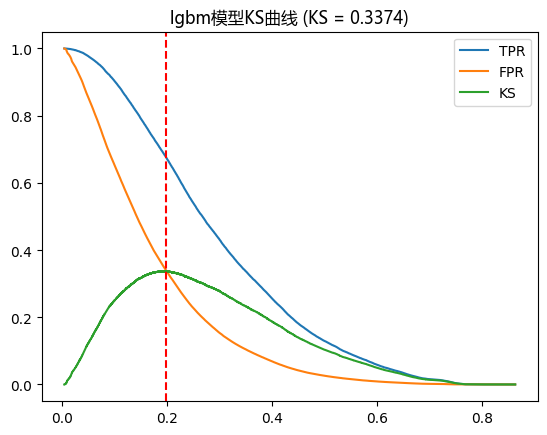

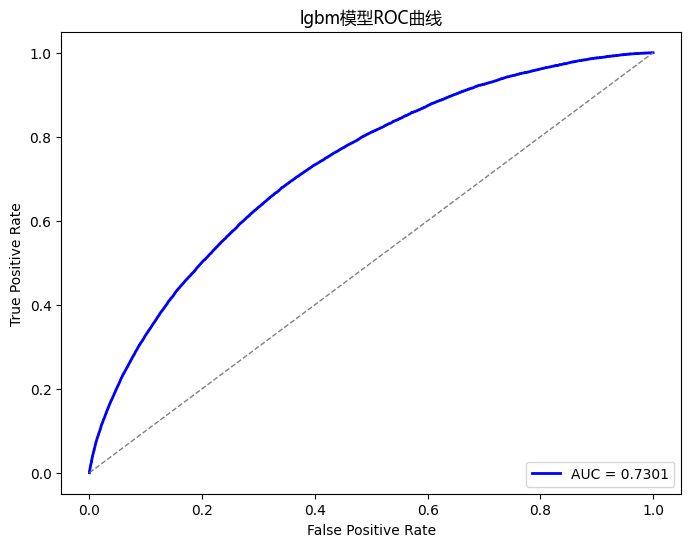

(None, 0.7300717362230214)

In [ ]:
plot_ks(y_test, y_pred_lgb_pro,'lgbm模型'), plot_roc(y_test, y_pred_lgb_pro, 'lgbm模型')

## 1.4拆分后的数据用逻辑回归

In [ ]:
import pandas as pd  
from sklearn.model_selection import train_test_split  

# 选择特征和目标变量  
X = train_woe.drop(columns=['isDefault'])  # 假设目标变量为 'isDefault'  
y = train_woe['isDefault']  

# 划分数据集  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  

In [ ]:
from sklearn.linear_model import LogisticRegression
# 创建逻辑回归模型  
model = LogisticRegression()
# 训练模型  
model.fit(X_train, y_train)  

# 预测概率  
y_pred_lg_pro = model.predict_proba(X_test)[:, 1]  # 获取正类的概率  
y_pred_lg = [1 if score >=0.5 else 0 for score in y_pred_lg_pro]

In [ ]:
coefficients = model.coef_[0]  # 取第一个（也是唯一的）系数数组
coef_series = pd.Series(coefficients, index=X.columns)

# 按绝对值排序，方便查看影响最大的变量
coef_series_abs = coef_series.abs().sort_values(ascending=False)

print("各变量的系数（包括正负关系）：")
print(coef_series)

print("\n影响最大的变量（绝对值最大）：")
print(coef_series_abs)

各变量的系数（包括正负关系）：
loanAmnt              0.082694
term                  0.205302
subGrade              0.457810
employmentTitle      -0.030200
homeOwnership         0.128819
annualIncome         -0.221966
verificationStatus    0.057473
issueDate            -0.125221
purpose              -0.006783
dti                   0.075295
ficoRangeLow         -0.177685
revolUtil            -0.014834
earliesCreditLine    -0.031766
title                -0.006020
n2                    0.079529
n14                   0.062143
dtype: float64

影响最大的变量（绝对值最大）：
subGrade              0.457810
annualIncome          0.221966
term                  0.205302
ficoRangeLow          0.177685
homeOwnership         0.128819
issueDate             0.125221
loanAmnt              0.082694
n2                    0.079529
dti                   0.075295
n14                   0.062143
verificationStatus    0.057473
earliesCreditLine     0.031766
employmentTitle       0.030200
revolUtil             0.014834
purpose               

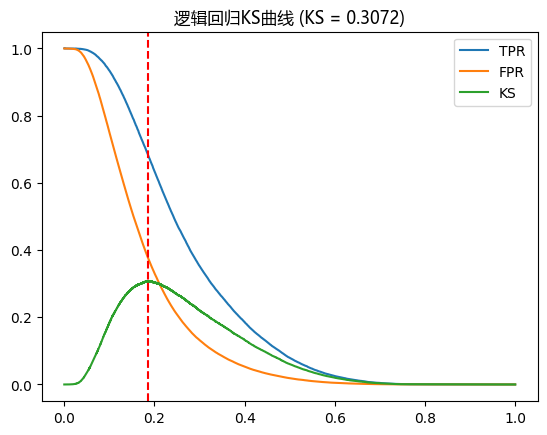

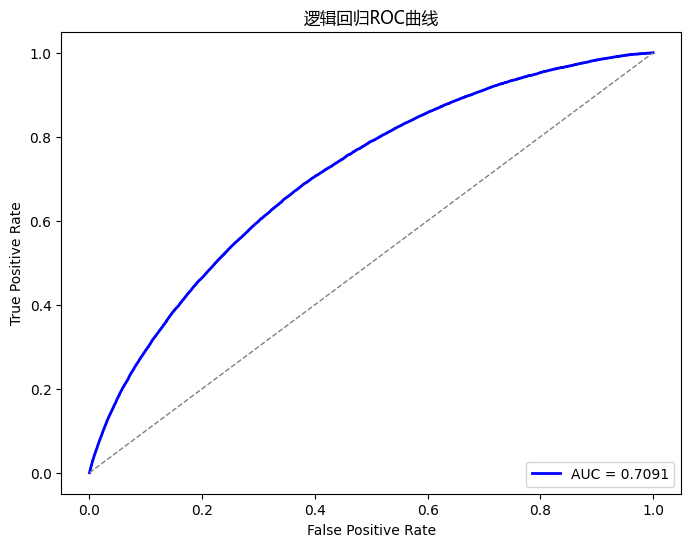

(None, 0.7091079478624873)

In [ ]:
plot_ks(y_test, y_pred_lg_pro,'逻辑回归'), plot_roc(y_test, y_pred_lg_pro,'逻辑回归')

In [ ]:
print(classification_report(y_test, y_pred_lg))
print(report(y_test, y_pred_lg_pro))

              precision    recall  f1-score   support

           0       0.80      1.00      0.89    121217
           1       0.23      0.00      0.00     30587

    accuracy                           0.80    151804
   macro avg       0.51      0.50      0.44    151804
weighted avg       0.68      0.80      0.71    151804

KS Value: 0.1859; AUC: 0.6301303710855648


## 1.5拆分后的数据用神经网络

Epoch [10/100], Loss: 0.5389
Epoch [20/100], Loss: 0.4938
Epoch [30/100], Loss: 0.4740
Epoch [40/100], Loss: 0.4628
Epoch [50/100], Loss: 0.4588
Epoch [60/100], Loss: 0.4570
Epoch [70/100], Loss: 0.4555
Epoch [80/100], Loss: 0.4544
Epoch [90/100], Loss: 0.4535
Epoch [100/100], Loss: 0.4527


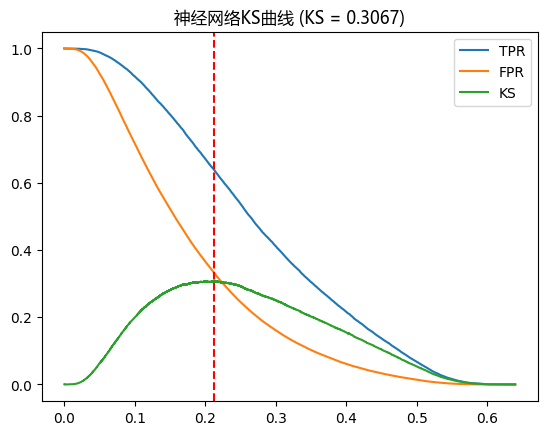

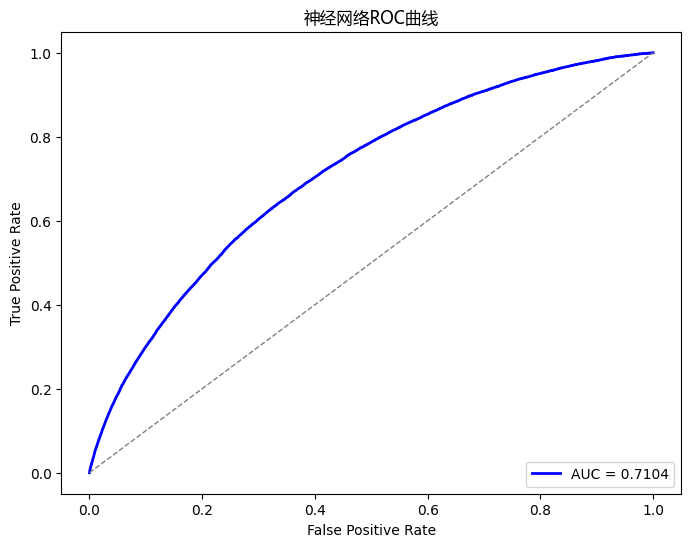

(None, 0.7103719054206229)

In [ ]:
import torch  
import torch.nn as nn  
import torch.optim as optim  
from sklearn.model_selection import train_test_split  
from sklearn.datasets import make_classification  
from sklearn.preprocessing import StandardScaler  
from sklearn.metrics import classification_report, confusion_matrix  
import torch  
import torch.nn as nn  
import torch.optim as optim  
from sklearn.model_selection import train_test_split  
from sklearn.datasets import make_classification  
from sklearn.preprocessing import StandardScaler  
from sklearn.metrics import classification_report, confusion_matrix  
 

# 数据标准化  
scaler = StandardScaler()  
X_train = scaler.fit_transform(X_train)  
X_test = scaler.transform(X_test)  

# 转换为 PyTorch 张量  
X_train_tensor = torch.FloatTensor(X_train)  
y_train_tensor = torch.FloatTensor(y_train.to_numpy())  # 确保转换为 NumPy  
X_test_tensor = torch.FloatTensor(X_test)  
y_test_tensor = torch.FloatTensor(y_test.to_numpy())    # 确保转换为 NumPy  

# 定义神经网络模型  
class SimpleNN(nn.Module):  
    def __init__(self):  
        super(SimpleNN, self).__init__()  
        self.fc1 = nn.Linear(16, 128)  # 输入层到第一隐藏层  
        self.fc2 = nn.Linear(128, 64)   # 第一隐藏层到第二隐藏层  
        self.fc3 = nn.Linear(64, 1)    # 第二隐藏层到输出层  
        
    def forward(self, x):  
        x = torch.relu(self.fc1(x))    # 第一层激活  
        x = torch.relu(self.fc2(x))    # 第二层激活   
        return torch.sigmoid(self.fc3(x))  # 输出层激活    

# 初始化模型、损失函数和优化器  
model = SimpleNN()  
criterion = nn.BCELoss()  # 二元交叉熵损失  
optimizer = optim.Adam(model.parameters(), lr=0.001)  

# 训练模型  
num_epochs = 100  
for epoch in range(num_epochs):  
    model.train()  
    optimizer.zero_grad()  
    outputs = model(X_train_tensor).squeeze()  # 前向传播  
    loss = criterion(outputs, y_train_tensor)  # 计算损失  
    loss.backward()  # 反向传播  
    optimizer.step()  # 更新权重  

    if (epoch + 1) % 10 == 0:  
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')  

# 预测  
model.eval()  
with torch.no_grad():  
    y_pred_proba = model(X_test_tensor).squeeze()  
    y_pred = (y_pred_proba >= 0.5).int()  # 将概率转换为类标签  

# 输出分类报告和混淆矩阵   
plot_ks(y_test, y_pred_proba, '神经网络'), plot_roc(y_test, y_pred_proba, '神经网络')

In [ ]:
col = X_train.columns.to_list()

In [ ]:
col = col+['xgb', 'lgb', 'NN']

In [ ]:
col.append('isDefault')

## 1.6将xgb，lgbm，神经网络输出放进逻辑回归

In [ ]:
data = final_data[col]

In [ ]:
data

,loanAmnt,term,subGrade,employmentTitle,homeOwnership,annualIncome,verificationStatus,issueDate,purpose,dti,ficoRangeLow,revolUtil,earliesCreditLine,title,n2,n14,xgb,lgb,NN,isDefault
0,35000.0,5,22,320.0,2,110000.0,2,130,1,17.05,730.0,48.9,285,1.0,2.0,2.0,0.285875,0.270102,0.410864,1
2,12000.0,5,18,31698.0,0,74000.0,2,115,0,22.77,675.0,51.8,228,0.0,3.0,4.0,0.409563,0.418654,0.394608,0
3,11000.0,3,4,46854.0,1,118000.0,1,117,4,17.21,685.0,52.6,312,4.0,6.0,1.0,0.064976,0.066371,0.093776,0
4,3000.0,3,12,54.0,1,29000.0,2,110,10,32.16,690.0,32.0,573,11.0,7.0,4.0,0.390527,0.398619,0.268089,0
5,11000.0,3,5,51727.0,0,39000.0,2,97,9,17.14,730.0,31.1,322,10.0,2.0,0.0,0.096341,0.096342,0.040768,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799995,25000.0,3,14,2659.0,1,72000.0,0,106,0,19.03,710.0,46.4,165,0.0,10.0,3.0,0.388316,0.371016,0.283629,0
799996,17000.0,3,4,29205.0,0,99000.0,2,145,4,15.72,720.0,98.4,432,33369.0,2.0,0.0,0.036667,0.037393,0.044212,0
799997,6000.0,3,13,2582.0,1,65000.0,2,115,0,12.11,670.0,51.9,274,0.0,4.0,4.0,0.180456,0.177899,0.226215,1
799998,19200.0,3,4,151.0,0,96000.0,2,123,4,29.25,675.0,61.3,376,4.0,8.0,5.0,0.062857,0.064642,0.089776,0


In [ ]:
from sklearn.linear_model import LogisticRegression
# 创建逻辑回归模型  
model = LogisticRegression()
# 训练模型  
model.fit(X_train, y_train)  

# 预测概率  
y_pred_lg_pro = model.predict_proba(X_test)[:, 1]  # 获取正类的概率  
y_pred_lg = [1 if score >=0.5 else 0 for score in y_pred_lg_pro]

c:\Users\谭艺星\OneDrive\桌面\毕业设计\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


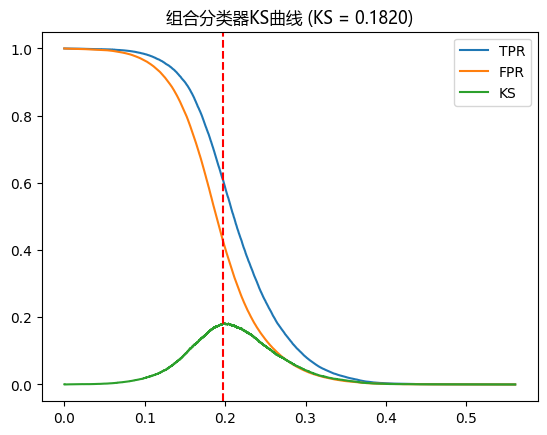

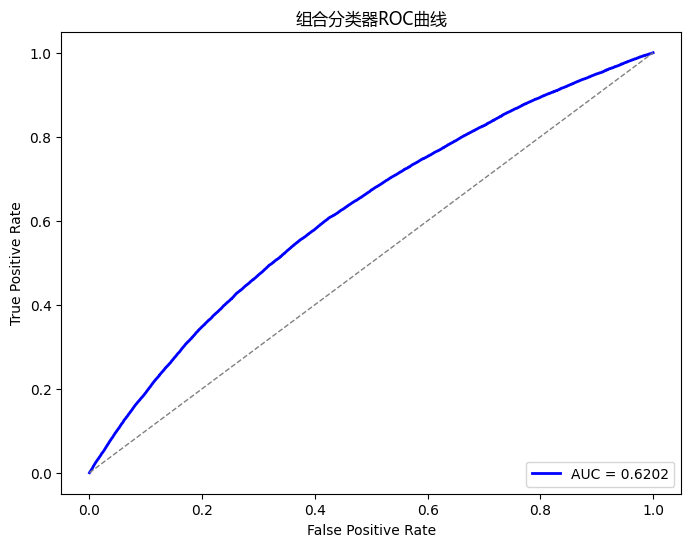

(None, 0.6202368201718134)

In [ ]:
plot_ks(y_test, y_pred_lg_pro, '组合分类器'), plot_roc(y_test, y_pred_lg_pro, '组合分类器')

# 2.直接把数据全丢进去建模

## 2.1数据预处理

In [125]:
data = pd.read_csv('train.csv')

In [4]:
data.columns

Index(['id', 'loanAmnt', 'term', 'interestRate', 'installment', 'grade',
       'subGrade', 'employmentTitle', 'employmentLength', 'homeOwnership',
       'annualIncome', 'verificationStatus', 'issueDate', 'isDefault',
       'purpose', 'postCode', 'regionCode', 'dti', 'delinquency_2years',
       'ficoRangeLow', 'ficoRangeHigh', 'openAcc', 'pubRec',
       'pubRecBankruptcies', 'revolBal', 'revolUtil', 'totalAcc',
       'initialListStatus', 'applicationType', 'earliesCreditLine', 'title',
       'policyCode', 'n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8',
       'n9', 'n10', 'n11', 'n12', 'n13', 'n14'],
      dtype='object')

In [126]:
data.drop(columns='id',inplace=True)    #去除id列

In [127]:
type(data.loc[0,'issueDate'])

str

In [128]:
print(data.dtypes)

loanAmnt              float64
term                    int64
interestRate          float64
installment           float64
grade                  object
subGrade               object
employmentTitle       float64
employmentLength       object
homeOwnership           int64
annualIncome          float64
verificationStatus      int64
issueDate              object
isDefault               int64
purpose                 int64
postCode              float64
regionCode              int64
dti                   float64
delinquency_2years    float64
ficoRangeLow          float64
ficoRangeHigh         float64
openAcc               float64
pubRec                float64
pubRecBankruptcies    float64
revolBal              float64
revolUtil             float64
totalAcc              float64
initialListStatus       int64
applicationType         int64
earliesCreditLine      object
title                 float64
policyCode            float64
n0                    float64
n1                    float64
n2        

In [129]:
data['earliesCreditLine'].value_counts()

earliesCreditLine
Aug-2001    5567
Sep-2003    5403
Aug-2002    5403
Oct-2001    5258
Aug-2000    5246
            ... 
Feb-1960       1
Sep-1957       1
Jul-1955       1
May-1960       1
Jan-1946       1
Name: count, Length: 720, dtype: int64

In [130]:
# 计算issueedate距今时间
from datetime import datetime  

def calculate_months_difference(date_str):  
    """  
    计算当前日期与给定日期之间的月份差  
    
    参数:  
    date_str: 字符串，格式为 'YYYY-MM-DD'  
    
    返回:  
    整数，表示月份差  
    """  
    # 将字符串转换为日期对象  
    given_date = datetime.strptime(date_str, '%Y-%m-%d')  
    current_date = datetime.now()  
    
    # 计算年差和月差  
    year_diff = current_date.year - given_date.year  
    month_diff = current_date.month - given_date.month  
    
    # 计算总的月份差  
    total_months_diff = year_diff * 12 + month_diff  
    
    return total_months_diff  

data['issueDate'] = data['issueDate'].apply(lambda x :calculate_months_difference(x))

In [131]:
# 将 'earliesCreditLine' 列转换为 datetime 格式并计算和现在时间的差值
data['earliesCreditLine'] = pd.to_datetime(data['earliesCreditLine'], format='%b-%Y')

In [132]:
data['earliesCreditLine'] = data['earliesCreditLine'].astype('str')
data['earliesCreditLine'] = data['earliesCreditLine'].apply(lambda x :calculate_months_difference(x))

In [8]:
# object类型转category
data['grade'] = data['grade'].astype('category')
data['subGrade'] = data['subGrade'].astype('category')

In [134]:
# 对这两个类别的另一个处理方式
mapping = {f'{chr(c)}{r}': idx for idx, (c, r) in enumerate([(i, j) for i in range(ord('A'), ord('G') + 1) for j in range(1, 6)], 1)}

In [135]:
mapping

{'A1': 1,
 'A2': 2,
 'A3': 3,
 'A4': 4,
 'A5': 5,
 'B1': 6,
 'B2': 7,
 'B3': 8,
 'B4': 9,
 'B5': 10,
 'C1': 11,
 'C2': 12,
 'C3': 13,
 'C4': 14,
 'C5': 15,
 'D1': 16,
 'D2': 17,
 'D3': 18,
 'D4': 19,
 'D5': 20,
 'E1': 21,
 'E2': 22,
 'E3': 23,
 'E4': 24,
 'E5': 25,
 'F1': 26,
 'F2': 27,
 'F3': 28,
 'F4': 29,
 'F5': 30,
 'G1': 31,
 'G2': 32,
 'G3': 33,
 'G4': 34,
 'G5': 35}

In [136]:
mapping1 = {'A': 3, 'B': 8, 'C':13, 'D':18, 'E':23, 'F':28, 'G':33}

In [137]:
data['grade'] = data['grade'].map(mapping1)
data['subGrade'] = data['subGrade'].map(mapping)

In [138]:
# 将就业年限映射为数字
# 创建一个映射字典  
employment_length_mapping = {  
    '10+ years': 10,  
    '2 years': 2,  
    '< 1 year': 0,  
    '3 years': 3,  
    '1 year': 1,  
    '4 years': 4,  
    '5 years': 5,  
    '6 years': 6,  
    '7 years': 7,  
    '8 years': 8,  
    '9 years': 9,  
}  

# 替换数据  
data['employmentLength'] = data['employmentLength'].map(employment_length_mapping)  

In [139]:
data

,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,homeOwnership,annualIncome,...,n5,n6,n7,n8,n9,n10,n11,n12,n13,n14
0,35000.0,5,19.52,917.97,23,22,320.0,2.0,2,110000.0,...,9.0,8.0,4.0,12.0,2.0,7.0,0.0,0.0,0.0,2.0
1,18000.0,5,18.49,461.90,18,17,219843.0,5.0,0,46000.0,...,NaN,NaN,NaN,NaN,NaN,13.0,NaN,NaN,NaN,NaN
2,12000.0,5,16.99,298.17,18,18,31698.0,8.0,0,74000.0,...,0.0,21.0,4.0,5.0,3.0,11.0,0.0,0.0,0.0,4.0
3,11000.0,3,7.26,340.96,3,4,46854.0,10.0,1,118000.0,...,16.0,4.0,7.0,21.0,6.0,9.0,0.0,0.0,0.0,1.0
4,3000.0,3,12.99,101.07,13,12,54.0,NaN,1,29000.0,...,4.0,9.0,10.0,15.0,7.0,12.0,0.0,0.0,0.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799995,25000.0,3,14.49,860.41,13,14,2659.0,7.0,1,72000.0,...,6.0,2.0,12.0,13.0,10.0,14.0,0.0,0.0,0.0,3.0
799996,17000.0,3,7.90,531.94,3,4,29205.0,10.0,0,99000.0,...,15.0,16.0,2.0,19.0,2.0,7.0,0.0,0.0,0.0,0.0
799997,6000.0,3,13.33,203.12,13,13,2582.0,10.0,1,65000.0,...,4.0,26.0,4.0,10.0,4.0,5.0,0.0,0.0,1.0,4.0
799998,19200.0,3,6.92,592.14,3,4,151.0,10.0,0,96000.0,...,10.0,6.0,12.0,22.0,8.0,16.0,0.0,0.0,0.0,5.0


In [144]:
final_data = data.copy()

In [143]:
data

,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,homeOwnership,annualIncome,...,n5,n6,n7,n8,n9,n10,n11,n12,n13,n14
0,35000.0,5,19.52,917.97,23,22,320.0,2.0,2,110000.0,...,9.0,8.0,4.0,12.0,2.0,7.0,0.0,0.0,0.0,2.0
1,18000.0,5,18.49,461.90,18,17,219843.0,5.0,0,46000.0,...,NaN,NaN,NaN,NaN,NaN,13.0,NaN,NaN,NaN,NaN
2,12000.0,5,16.99,298.17,18,18,31698.0,8.0,0,74000.0,...,0.0,21.0,4.0,5.0,3.0,11.0,0.0,0.0,0.0,4.0
3,11000.0,3,7.26,340.96,3,4,46854.0,10.0,1,118000.0,...,16.0,4.0,7.0,21.0,6.0,9.0,0.0,0.0,0.0,1.0
4,3000.0,3,12.99,101.07,13,12,54.0,NaN,1,29000.0,...,4.0,9.0,10.0,15.0,7.0,12.0,0.0,0.0,0.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799995,25000.0,3,14.49,860.41,13,14,2659.0,7.0,1,72000.0,...,6.0,2.0,12.0,13.0,10.0,14.0,0.0,0.0,0.0,3.0
799996,17000.0,3,7.90,531.94,3,4,29205.0,10.0,0,99000.0,...,15.0,16.0,2.0,19.0,2.0,7.0,0.0,0.0,0.0,0.0
799997,6000.0,3,13.33,203.12,13,13,2582.0,10.0,1,65000.0,...,4.0,26.0,4.0,10.0,4.0,5.0,0.0,0.0,1.0,4.0
799998,19200.0,3,6.92,592.14,3,4,151.0,10.0,0,96000.0,...,10.0,6.0,12.0,22.0,8.0,16.0,0.0,0.0,0.0,5.0


In [23]:
final_data.to_csv('data.csv')

In [254]:
final_data = pd.read_csv('final_data.csv')

In [256]:
final_data.drop(columns=['Unnamed: 0', 'xgb', 'lgb','NN'], inplace=True)

In [147]:
final_data.dropna(axis=0, how='any', inplace=True)

In [257]:
final_data

,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,homeOwnership,annualIncome,verificationStatus,...,n5,n6,n7,n8,n9,n10,n11,n12,n13,n14
0,35000.0,5,19.52,917.97,23,22,320.0,2,110000.0,2,...,9.0,8.0,4.0,12.0,2.0,7.0,0.0,0.0,0.0,2.0
1,12000.0,5,16.99,298.17,18,18,31698.0,0,74000.0,2,...,0.0,21.0,4.0,5.0,3.0,11.0,0.0,0.0,0.0,4.0
2,11000.0,3,7.26,340.96,3,4,46854.0,1,118000.0,1,...,16.0,4.0,7.0,21.0,6.0,9.0,0.0,0.0,0.0,1.0
3,3000.0,3,12.99,101.07,13,12,54.0,1,29000.0,2,...,4.0,9.0,10.0,15.0,7.0,12.0,0.0,0.0,0.0,4.0
4,11000.0,3,7.99,344.65,3,5,51727.0,0,39000.0,2,...,1.0,48.0,2.0,3.0,2.0,19.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729529,25000.0,3,14.49,860.41,13,14,2659.0,1,72000.0,0,...,6.0,2.0,12.0,13.0,10.0,14.0,0.0,0.0,0.0,3.0
729530,17000.0,3,7.90,531.94,3,4,29205.0,0,99000.0,2,...,15.0,16.0,2.0,19.0,2.0,7.0,0.0,0.0,0.0,0.0
729531,6000.0,3,13.33,203.12,13,13,2582.0,1,65000.0,2,...,4.0,26.0,4.0,10.0,4.0,5.0,0.0,0.0,1.0,4.0
729532,19200.0,3,6.92,592.14,3,4,151.0,0,96000.0,2,...,10.0,6.0,12.0,22.0,8.0,16.0,0.0,0.0,0.0,5.0


In [149]:
final_data.to_csv('data.csv')

## 2.2全部数据xgb建模

In [259]:
import pandas as pd  
from sklearn.model_selection import train_test_split  

# 选择特征和目标变量  
X = final_data.drop(columns=['isDefault'])  # 假设目标变量为 'isDefault'  
y = final_data['isDefault']  

# 划分数据集  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  
scaler = StandardScaler()  
X_train = scaler.fit_transform(X_train)  
X_test = scaler.transform(X_test)  

In [152]:
import xgboost as xgb  
from sklearn.metrics import accuracy_score  

# 初始化模型  
xgb_model = xgb.XGBClassifier(
    use_label_encoder=False,  
    eval_metric='logloss',  
    max_depth=6,  
    learning_rate=0.01,  
    n_estimators=1000,  
    subsample=0.8,  
    colsample_bytree=0.8,  
    gamma=0,  
    random_state=42,
    enable_categorical=True  
)  
# 训练模型  
xgb_model.fit(X_train, y_train)  

# 预测  
y_pred_xgb = xgb_model.predict(X_test)  
y_pred_xgb_pro = xgb_model.predict_proba(X_test)[:,1]
#print(classification_report(y_test, y_pred_xgb))
#print(report(y_test, y_pred_xgb_pro))

c:\Users\谭艺星\OneDrive\桌面\毕业设计\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:24:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


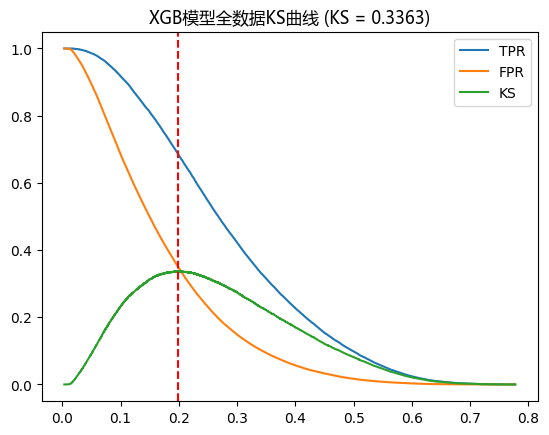

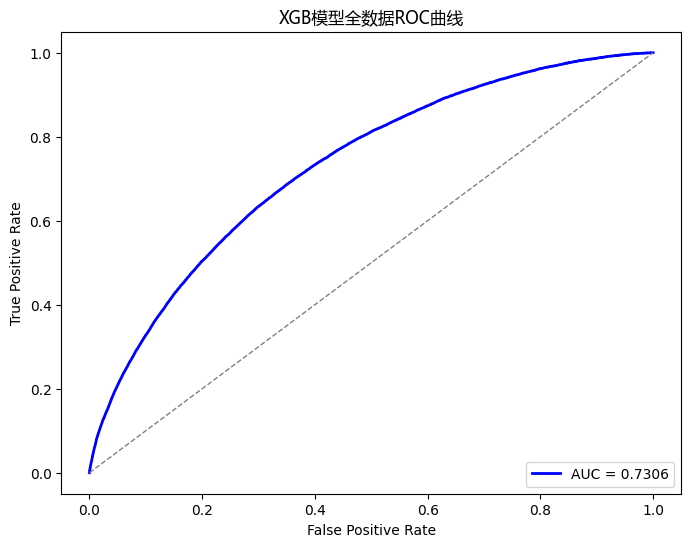

(None, 0.7306014883343024)

In [153]:
plot_ks(y_test, y_pred_xgb_pro,'XGB模型全数据'), plot_roc(y_test, y_pred_xgb_pro, 'XGB模型全数据')

## 2.3全部数据用lgb建模

In [154]:
import lightgbm as lgb  

# 创建数据集  
lgb_train = lgb.Dataset(X_train, label=y_train)  
lgb_test = lgb.Dataset(X_test, label=y_test, reference=lgb_train)  

# 设置参数  
params = {  
    'objective': 'binary',  
    'metric': 'binary_logloss',  
    'boosting_type': 'gbdt',  
    'num_leaves': 31,  
    'learning_rate': 0.01,  
    'feature_fraction': 0.8,  
    'bagging_fraction': 0.8,  
    'bagging_freq': 5,  
    'verbose': -1 
}  

# 训练模型  
lgb_model = lgb.train(params, lgb_train, valid_sets=lgb_test, num_boost_round=1000)

# 预测  
y_pred_lgb_pro = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration) 
y_pred_lgb = [1 if score >=0.5 else 0 for score in y_pred_lgb_pro]
#print(classification_report(y_test, y_pred_lgb))
#print(report(y_test, y_pred_lgb_pro))     

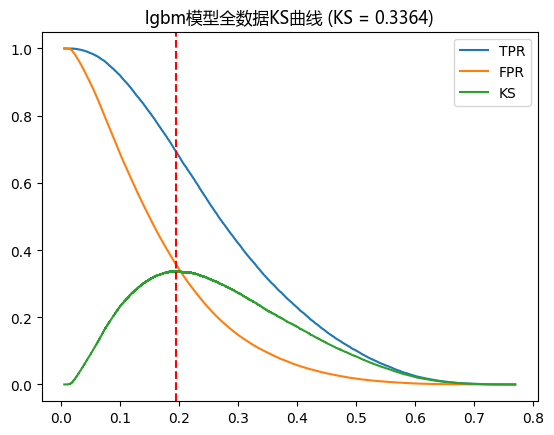

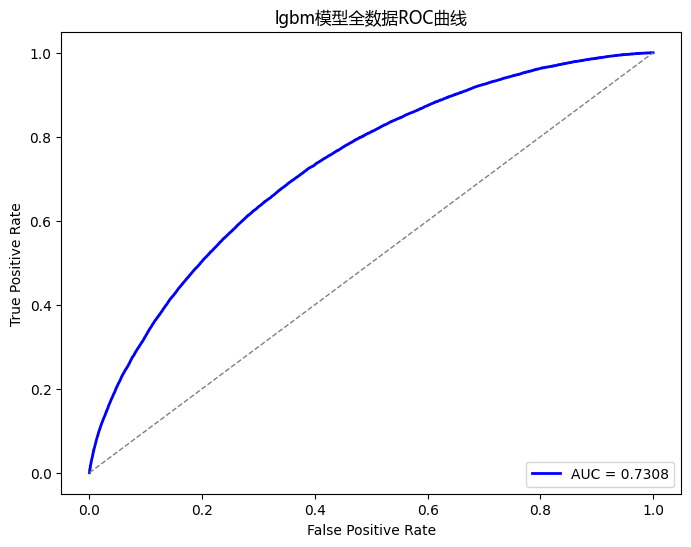

(None, 0.7307639103128172)

In [157]:
plot_ks(y_test, y_pred_lgb_pro,'lgbm模型全数据'), plot_roc(y_test, y_pred_lgb_pro, 'lgbm模型全数据')

## 2.4全部数据用逻辑回归

In [260]:
from sklearn.linear_model import LogisticRegression
# 创建逻辑回归模型  
model = LogisticRegression()
# 训练模型  
model.fit(X_train, y_train)  

# 预测概率  
y_pred_prob = model.predict_proba(X_test)[:, 1]  # 获取正类的概率  
y_pred = [1 if score >=0.5 else 0 for score in y_pred_prob]
#print(classification_report(y_test, y_pred))
#print(report(y_test, y_pred_prob))  

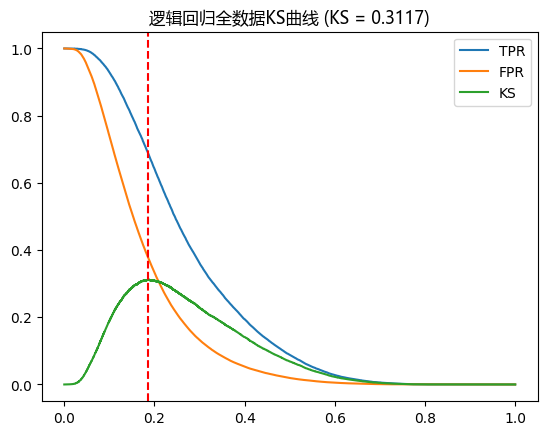

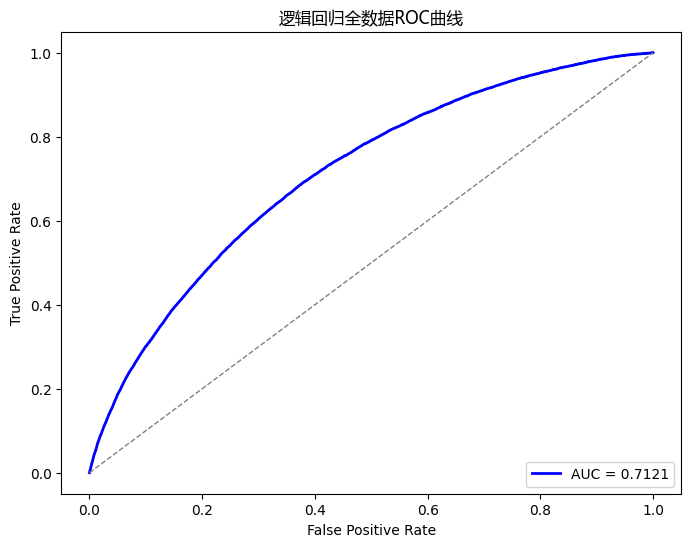

(None, 0.7120632044968701)

In [261]:
plot_ks(y_test, y_pred_prob,'逻辑回归全数据'), plot_roc(y_test, y_pred_prob, '逻辑回归全数据')

## 2.5全部数据用神经网络

In [159]:
X = final_data.drop(columns=['isDefault'])  # 假设目标变量为 'isDefault'  
y = final_data['isDefault']  

# 划分数据集  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

In [160]:
import torch  
import torch.nn as nn  
import torch.optim as optim  
from sklearn.model_selection import train_test_split  
from sklearn.datasets import make_classification  
from sklearn.preprocessing import StandardScaler  
from sklearn.metrics import classification_report, confusion_matrix  
import torch  
import torch.nn as nn  
import torch.optim as optim  
from sklearn.model_selection import train_test_split  
from sklearn.datasets import make_classification  
from sklearn.preprocessing import StandardScaler  
from sklearn.metrics import classification_report, confusion_matrix  
 

# 数据标准化  
scaler = StandardScaler()  
X_train = scaler.fit_transform(X_train)  
X_test = scaler.transform(X_test)  

# 转换为 PyTorch 张量  
X_train_tensor = torch.FloatTensor(X_train)  
y_train_tensor = torch.FloatTensor(y_train.to_numpy())  # 确保转换为 NumPy  
X_test_tensor = torch.FloatTensor(X_test)  
y_test_tensor = torch.FloatTensor(y_test.to_numpy())    # 确保转换为 NumPy  

# 定义神经网络模型  
class SimpleNN(nn.Module):  
    def __init__(self):  
        super(SimpleNN, self).__init__()  
        self.fc1 = nn.Linear(44, 128)  # 输入层到第一隐藏层  
        self.fc2 = nn.Linear(128, 64)   # 第一隐藏层到第二隐藏层  
        self.fc3 = nn.Linear(64, 1)    # 第二隐藏层到输出层  
        
    def forward(self, x):  
        x = torch.relu(self.fc1(x))    # 第一层激活  
        x = torch.relu(self.fc2(x))    # 第二层激活   
        return torch.sigmoid(self.fc3(x))  # 输出层激活    

# 初始化模型、损失函数和优化器  
model = SimpleNN()  
criterion = nn.BCELoss()  # 二元交叉熵损失  
optimizer = optim.Adam(model.parameters(), lr=0.001)  

# 训练模型  
num_epochs = 100  
for epoch in range(num_epochs):  
    model.train()  
    optimizer.zero_grad()  
    outputs = model(X_train_tensor).squeeze()  # 前向传播  
    loss = criterion(outputs, y_train_tensor)  # 计算损失  
    loss.backward()  # 反向传播  
    optimizer.step()  # 更新权重  

    if (epoch + 1) % 10 == 0:  
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')  

# 预测  
model.eval()  
with torch.no_grad():  
    y_pred_proba = model(X_test_tensor).squeeze()  
    y_pred = (y_pred_proba >= 0.5).int()  # 将概率转换为类标签  

# 输出分类报告和混淆矩阵   
#print(confusion_matrix(y_test, y_pred.numpy()))  
#print(classification_report(y_test, y_pred.numpy()))
#print(report(y_test, y_pred_proba)) 

Epoch [10/100], Loss: 0.5241
Epoch [20/100], Loss: 0.4837
Epoch [30/100], Loss: 0.4666
Epoch [40/100], Loss: 0.4591
Epoch [50/100], Loss: 0.4565
Epoch [60/100], Loss: 0.4551
Epoch [70/100], Loss: 0.4541
Epoch [80/100], Loss: 0.4534
Epoch [90/100], Loss: 0.4527
Epoch [100/100], Loss: 0.4521


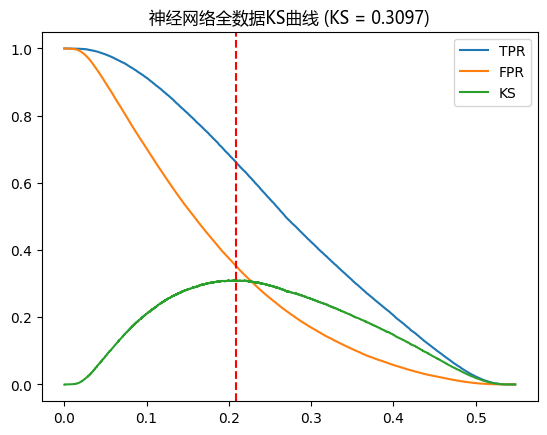

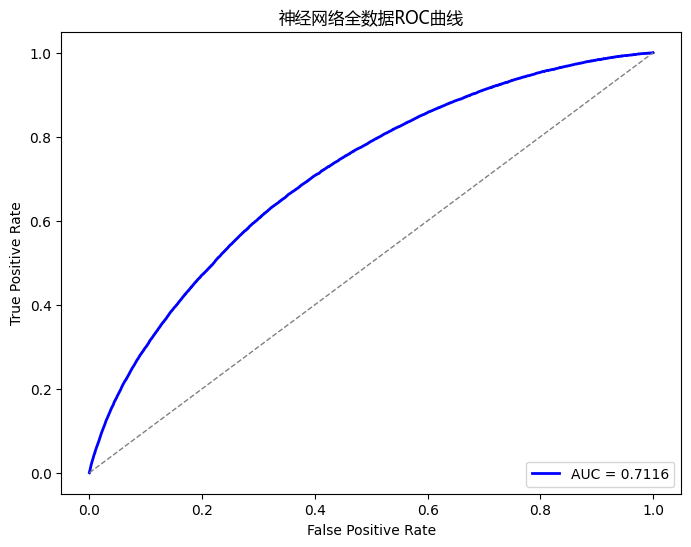

(None, 0.7116204217671336)

In [161]:
plot_ks(y_test, y_pred_proba,'神经网络全数据'), plot_roc(y_test, y_pred_proba, '神经网络全数据')

## 2.6尝试将xgb，lgbm的输出放进逻辑回归的输入

In [163]:
data1 = scaler.fit_transform(final_data.drop(columns=['isDefault', 'xgb','lgb']))
data1_tensor = torch.FloatTensor(data1)

In [164]:
final_data['xgb'] = xgb_model.predict_proba(X)[:,1]
final_data['lgb'] = lgb_model.predict(X, num_iteration=lgb_model.best_iteration)
model.eval()  
with torch.no_grad():  
    y_pred_proba = model(data1_tensor).squeeze()  # 预测概率
y_pred_proba_numpy = y_pred_proba.detach().numpy()
final_data['NN'] = y_pred_proba_numpy

In [165]:
final_data

,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,homeOwnership,annualIncome,verificationStatus,...,n8,n9,n10,n11,n12,n13,n14,xgb,lgb,NN
0,35000.0,5,19.52,917.97,23,22,320.0,2,110000.0,2,...,12.0,2.0,7.0,0.0,0.0,0.0,2.0,0.285875,0.270102,0.410864
2,12000.0,5,16.99,298.17,18,18,31698.0,0,74000.0,2,...,5.0,3.0,11.0,0.0,0.0,0.0,4.0,0.409563,0.418654,0.394608
3,11000.0,3,7.26,340.96,3,4,46854.0,1,118000.0,1,...,21.0,6.0,9.0,0.0,0.0,0.0,1.0,0.064976,0.066371,0.093776
4,3000.0,3,12.99,101.07,13,12,54.0,1,29000.0,2,...,15.0,7.0,12.0,0.0,0.0,0.0,4.0,0.390527,0.398619,0.268089
5,11000.0,3,7.99,344.65,3,5,51727.0,0,39000.0,2,...,3.0,2.0,19.0,0.0,0.0,0.0,0.0,0.096341,0.096342,0.040768
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799995,25000.0,3,14.49,860.41,13,14,2659.0,1,72000.0,0,...,13.0,10.0,14.0,0.0,0.0,0.0,3.0,0.388316,0.371016,0.283629
799996,17000.0,3,7.90,531.94,3,4,29205.0,0,99000.0,2,...,19.0,2.0,7.0,0.0,0.0,0.0,0.0,0.036667,0.037393,0.044212
799997,6000.0,3,13.33,203.12,13,13,2582.0,1,65000.0,2,...,10.0,4.0,5.0,0.0,0.0,1.0,4.0,0.180456,0.177899,0.226215
799998,19200.0,3,6.92,592.14,3,4,151.0,0,96000.0,2,...,22.0,8.0,16.0,0.0,0.0,0.0,5.0,0.062857,0.064642,0.089776


In [166]:
final_data.to_csv('final_data.csv')

In [ ]:
final_data.drop(columns=['xgb', 'lgb'])

In [38]:
# 选择特征和目标变量  
X = final_data.drop(columns=['isDefault'])  # 假设目标变量为 'isDefault'  
y = final_data['isDefault']  

# 划分数据集  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  

In [39]:
from sklearn.linear_model import LogisticRegression
# 创建逻辑回归模型  
model = LogisticRegression()
# 训练模型  
model.fit(X_train, y_train)  

# 预测概率  
y_pred_prob = model.predict_proba(X_test)[:, 1]  # 获取正类的概率  
y_pred = [1 if score >=0.5 else 0 for score in y_pred_prob]
print(classification_report(y_test, y_pred))
print(report(y_test, y_pred_prob))  

              precision    recall  f1-score   support

           0       0.80      1.00      0.89    116756
           1       0.43      0.00      0.00     29151

    accuracy                           0.80    145907
   macro avg       0.61      0.50      0.44    145907
weighted avg       0.73      0.80      0.71    145907

KS Value: 0.1857; AUC: 0.6234674956645526


c:\Users\谭艺星\OneDrive\桌面\毕业设计\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# 3.建立评分卡模型

In [217]:
data = pd.read_csv('final_data.csv')

In [218]:
data = data[col]

In [219]:
data

,loanAmnt,term,subGrade,employmentTitle,homeOwnership,annualIncome,verificationStatus,issueDate,purpose,dti,ficoRangeLow,revolUtil,earliesCreditLine,title,n2,n14,xgb,lgb,NN,isDefault
0,35000.0,5,22,320.0,2,110000.0,2,130,1,17.05,730.0,48.9,285,1.0,2.0,2.0,0.285876,0.270102,0.410864,1
1,12000.0,5,18,31698.0,0,74000.0,2,115,0,22.77,675.0,51.8,228,0.0,3.0,4.0,0.409563,0.418654,0.394608,0
2,11000.0,3,4,46854.0,1,118000.0,1,117,4,17.21,685.0,52.6,312,4.0,6.0,1.0,0.064976,0.066371,0.093776,0
3,3000.0,3,12,54.0,1,29000.0,2,110,10,32.16,690.0,32.0,573,11.0,7.0,4.0,0.390527,0.398619,0.268089,0
4,11000.0,3,5,51727.0,0,39000.0,2,97,9,17.14,730.0,31.1,322,10.0,2.0,0.0,0.096341,0.096342,0.040768,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729529,25000.0,3,14,2659.0,1,72000.0,0,106,0,19.03,710.0,46.4,165,0.0,10.0,3.0,0.388316,0.371016,0.283629,0
729530,17000.0,3,4,29205.0,0,99000.0,2,145,4,15.72,720.0,98.4,432,33369.0,2.0,0.0,0.036667,0.037393,0.044212,0
729531,6000.0,3,13,2582.0,1,65000.0,2,115,0,12.11,670.0,51.9,274,0.0,4.0,4.0,0.180456,0.177899,0.226215,1
729532,19200.0,3,4,151.0,0,96000.0,2,123,4,29.25,675.0,61.3,376,4.0,8.0,5.0,0.062857,0.064642,0.089776,0


In [4]:
data.drop(columns='Unnamed: 0', inplace=True)

In [262]:
data = pd.read_csv('final_data.csv')

In [264]:
data

,loanAmnt,term,subGrade,employmentTitle,homeOwnership,annualIncome,verificationStatus,issueDate,purpose,dti,ficoRangeLow,revolUtil,earliesCreditLine,title,n2,n14,xgb,lgb,NN,isDefault
0,35000.0,5,22,320.0,2,110000.0,2,130,1,17.05,730.0,48.9,285,1.0,2.0,2.0,0.285876,0.270102,0.410864,1
1,12000.0,5,18,31698.0,0,74000.0,2,115,0,22.77,675.0,51.8,228,0.0,3.0,4.0,0.409563,0.418654,0.394608,0
2,11000.0,3,4,46854.0,1,118000.0,1,117,4,17.21,685.0,52.6,312,4.0,6.0,1.0,0.064976,0.066371,0.093776,0
3,3000.0,3,12,54.0,1,29000.0,2,110,10,32.16,690.0,32.0,573,11.0,7.0,4.0,0.390527,0.398619,0.268089,0
4,11000.0,3,5,51727.0,0,39000.0,2,97,9,17.14,730.0,31.1,322,10.0,2.0,0.0,0.096341,0.096342,0.040768,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729529,25000.0,3,14,2659.0,1,72000.0,0,106,0,19.03,710.0,46.4,165,0.0,10.0,3.0,0.388316,0.371016,0.283629,0
729530,17000.0,3,4,29205.0,0,99000.0,2,145,4,15.72,720.0,98.4,432,33369.0,2.0,0.0,0.036667,0.037393,0.044212,0
729531,6000.0,3,13,2582.0,1,65000.0,2,115,0,12.11,670.0,51.9,274,0.0,4.0,4.0,0.180456,0.177899,0.226215,1
729532,19200.0,3,4,151.0,0,96000.0,2,123,4,29.25,675.0,61.3,376,4.0,8.0,5.0,0.062857,0.064642,0.089776,0


loanAmnt: [ 3512.5  9012.5 10012.5 14987.5 15012.5 19962.5 20012.5 24987.5 28037.5]
Train AUC: 0.7487
Test AUC: 0.7263


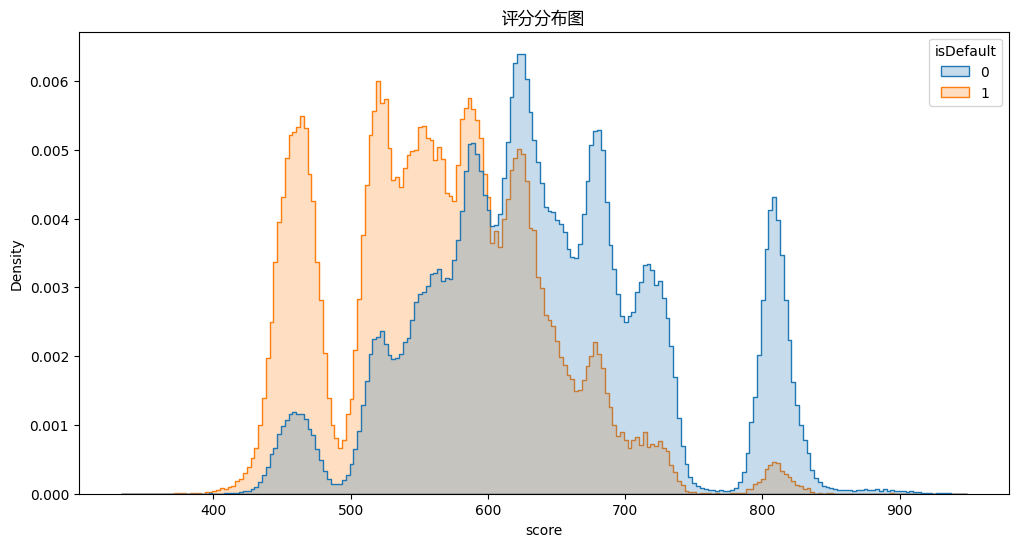

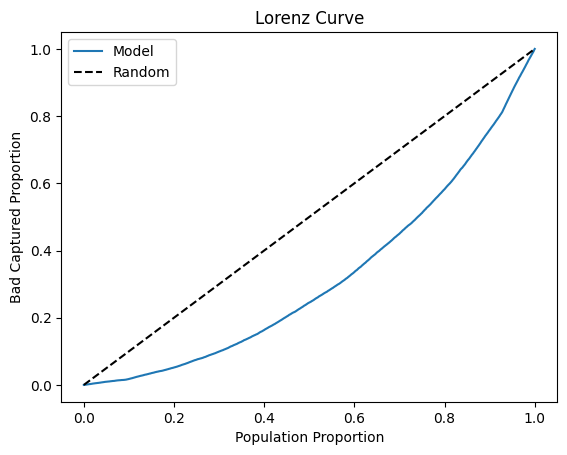

In [ ]:
# 安装必要库（如果未安装）
import toad
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
# 数据预处理
data.replace([np.inf, -np.inf], np.nan, inplace=True)
# 划分训练测试集
train, test = train_test_split(data, test_size=0.2, random_state=42)
# 使用toad进行分箱
c = toad.transform.Combiner()
c.fit(train,
    train['isDefault'],
    method='dt',
    min_samples=0.05,  # 最小分箱样本比例
    n_bins=10)
# 转换WOE值
transformer = toad.transform.WOETransformer()
train_woe = transformer.fit_transform(c.transform(train), train['isDefault'], exclude='isDefault')
test_woe = transformer.transform(c.transform(test))
# 训练逻辑回归模型
lr = LogisticRegression()
lr.fit(train_woe.drop('isDefault', axis=1), train_woe['isDefault'])
# 模型评估
from sklearn.metrics import roc_auc_score, roc_curve
prob_train = lr.predict_proba(train_woe.drop('isDefault', axis=1))[:,1]
prob_test = lr.predict_proba(test_woe.drop('isDefault', axis=1))[:,1]
# 评分卡转换
card = toad.ScoreCard(
    combiner = c,
    transer = transformer,
    base_score = 600,  # 基础分（必须）
    base_odds = 4,   # 基础odds（必须）
    pdo = 60,         # 分数刻度（必须）
    rate = 2          # odds翻倍率（可选）
)
card.fit(train_woe.drop(columns='isDefault'), train_woe['isDefault'])
# 生成评分
train['score'] = card.predict(train)
test['score'] = card.predict(test)

# ========== 可视化分析 ==========
'''
# 1. 特征分箱分析
plt.figure(figsize=(12, 6))
toad.plot.bin_plot(data, x='loanAmnt', target='isDefault', by=combiner['loanAmnt'])
plt.title('loanAmnt Distribution by Target')
plt.show()

# 2. WOE趋势分析
plt.figure(figsize=(10, 6))
toad.plot.woe_plot(transformer['loanAmnt'])
plt.title('WOE Transformation for loanAmnt')
plt.show()

# 3. 特征重要性
importance = toad.importance(lr, train_woe.drop('isDefault', axis=1), train_woe['isDefault'])
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='index', data=importance.reset_index())
plt.title('Feature Importance')
plt.show()
'''

# 5. 评分分布
plt.figure(figsize=(12, 6))
sns.histplot(data=train, x='score', hue='isDefault', element='step', stat='density', common_norm=False)
plt.title('评分分布图', fontname=my_font)
plt.show()

# 6. 评分排序能力
def plot_lorenz(y_true, y_pred):
    df = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
    df = df.sort_values('y_pred', ascending=False).reset_index(drop=True)
    df['cum_bad'] = df['y_true'].cumsum() / df['y_true'].sum()
    df['cum_pop'] = (df.index + 1) / len(df)
    
    plt.plot(df['cum_pop'], df['cum_bad'], label='Model')
    plt.plot([0,1], [0,1], 'k--', label='Random')
    plt.title('Lorenz Curve')
    plt.xlabel('Population Proportion')
    plt.ylabel('Bad Captured Proportion')
    plt.legend()
    plt.show()

plot_lorenz(test['isDefault'], test['score'])


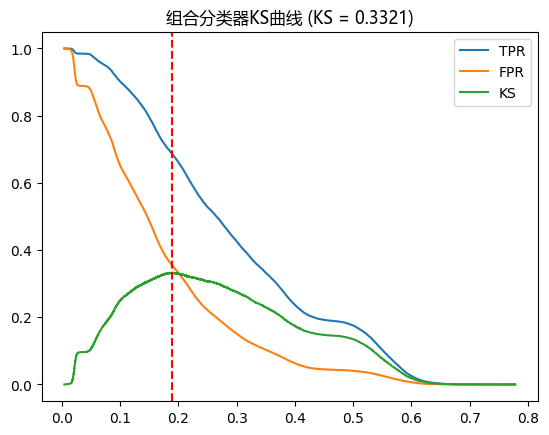

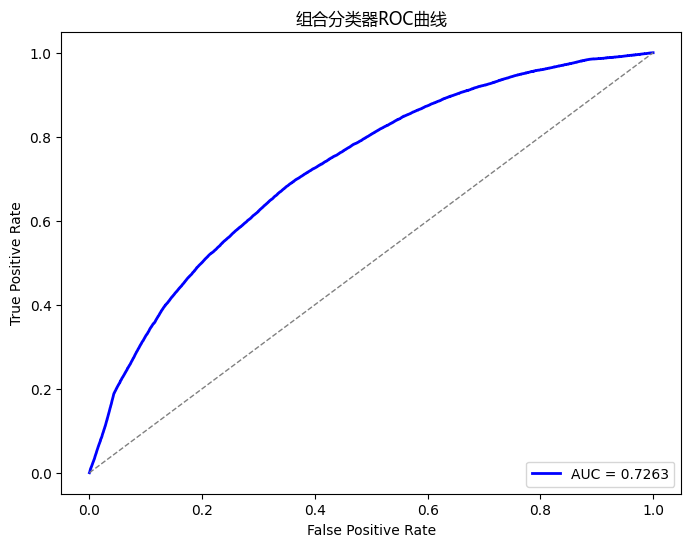

(None, 0.7262992256615647)

In [285]:
plot_ks(y_test, prob_test, '组合分类器'), plot_roc(y_test, prob_test, '组合分类器')

In [221]:
coefficients = lr.coef_[0]  # 由于是二分类，取第一个数组

# 将系数与特征列名关联
coef_series = pd.Series(coefficients, index=train_woe.drop(columns='isDefault').columns)

# 排序，查看影响最大的变量
coef_sorted = coef_series.abs().sort_values(ascending=False)

print("各变量的系数：")
print(coef_series)

print("\n影响最显著的变量（绝对值）：")
print(coef_sorted)

各变量的系数：
loanAmnt              0.037080
term                  0.051517
subGrade             -0.032312
employmentTitle       0.097847
homeOwnership         0.109860
annualIncome          0.139635
verificationStatus    0.054622
issueDate             0.037542
purpose               0.064966
dti                   0.048724
ficoRangeLow          0.138156
revolUtil             0.140645
earliesCreditLine     0.023099
title                 0.003346
n2                    0.073841
n14                   0.140010
xgb                   0.888045
lgb                   0.095971
NN                   -0.035408
dtype: float64

影响最显著的变量（绝对值）：
xgb                   0.888045
revolUtil             0.140645
n14                   0.140010
annualIncome          0.139635
ficoRangeLow          0.138156
homeOwnership         0.109860
employmentTitle       0.097847
lgb                   0.095971
n2                    0.073841
purpose               0.064966
verificationStatus    0.054622
term                  0.051517


In [286]:
# 10组
coefficients = lr.coef_[0]  # 由于是二分类，取第一个数组

# 将系数与特征列名关联
coef_series = pd.Series(coefficients, index=train_woe.drop(columns='isDefault').columns)

# 排序，查看影响最大的变量
coef_sorted = coef_series.abs().sort_values(ascending=False)

print("各变量的系数：")
print(coef_series)

print("\n影响最显著的变量（绝对值）：")
print(coef_sorted)

各变量的系数：
loanAmnt             -0.193552
term                 -0.140028
subGrade             -0.369404
employmentTitle      -0.161446
homeOwnership        -0.265258
annualIncome         -0.207981
verificationStatus   -0.047775
issueDate            -0.356872
purpose               0.073782
dti                  -0.116732
ficoRangeLow         -0.099699
revolUtil             0.271266
earliesCreditLine    -0.079254
title                -0.004629
n2                   -0.149846
n14                   0.021091
xgb                   1.450313
lgb                  -0.025306
NN                   -0.122911
dtype: float64

影响最显著的变量（绝对值）：
xgb                   1.450313
subGrade              0.369404
issueDate             0.356872
revolUtil             0.271266
homeOwnership         0.265258
annualIncome          0.207981
loanAmnt              0.193552
employmentTitle       0.161446
n2                    0.149846
term                  0.140028
NN                    0.122911
dti                   0.116732


In [287]:
card.export()

{'loanAmnt': {'[-inf ~ 3512.5)': 25.09,
  '[3512.5 ~ 9012.5)': 27.63,
  '[9012.5 ~ 10012.5)': 30.51,
  '[10012.5 ~ 14987.5)': 33.05,
  '[14987.5 ~ 15012.5)': 30.83,
  '[15012.5 ~ 19962.5)': 34.88,
  '[19962.5 ~ 20012.5)': 32.25,
  '[20012.5 ~ 24987.5)': 34.93,
  '[24987.5 ~ 28037.5)': 32.81,
  '[28037.5 ~ inf)': 35.92},
 'term': {'[-inf ~ 4.0)': 28.26, '[4.0 ~ inf)': 39.58},
 'subGrade': {'[-inf ~ 4.5)': -18.76,
  '[4.5 ~ 7.5)': 5.16,
  '[7.5 ~ 8.5)': 14.27,
  '[8.5 ~ 10.5)': 22.28,
  '[10.5 ~ 12.5)': 31.24,
  '[12.5 ~ 13.5)': 36.25,
  '[13.5 ~ 15.5)': 41.74,
  '[15.5 ~ 19.5)': 49.04,
  '[19.5 ~ 23.5)': 57.99,
  '[23.5 ~ inf)': 69.22},
 'employmentTitle': {'[-inf ~ 53.5)': 31.25,
  '[53.5 ~ 54.5)': 36.62,
  '[54.5 ~ 151.5)': 31.73,
  '[151.5 ~ 314.5)': 32.72,
  '[314.5 ~ 634.5)': 29.75,
  '[634.5 ~ 1321.5)': 30.66,
  '[1321.5 ~ 11093.5)': 31.97,
  '[11093.5 ~ 201313.5)': 31.55,
  '[201313.5 ~ 301232.5)': 27.85,
  '[301232.5 ~ inf)': 30.99},
 'homeOwnership': {'[-inf ~ 0.5)': 27.07,
  '

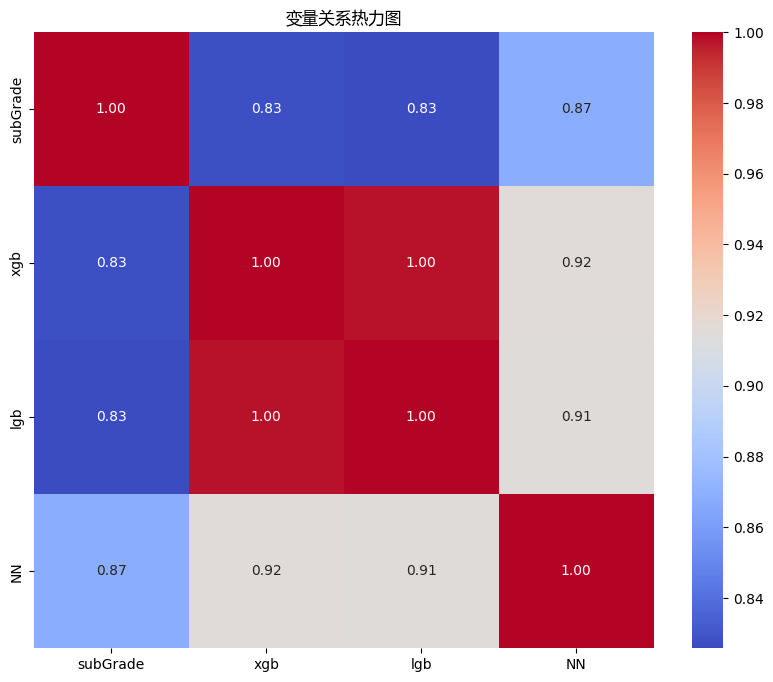

In [187]:
corr_matrix = data.corr()

# 只保留相关系数绝对值大于0.9的变量
# 将对角线元素（1.0）设为False，避免自己与自己比较
mask = np.abs(corr_matrix) > 0.6
np.fill_diagonal(mask.values, False)

# 筛选出相关度大于0.9的变量名
vars_to_show = corr_matrix.columns[mask.any()]

# 提取这些变量的相关性子矩阵
sub_corr = corr_matrix.loc[vars_to_show, vars_to_show]

# 绘制热力图
plt.figure(figsize=(10,8))
sns.heatmap(sub_corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('变量关系热力图', fontname=my_font)
plt.show()

c:\Users\谭艺星\OneDrive\桌面\毕业设计\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\谭艺星\OneDrive\桌面\毕业设计\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 25454 (\N{CJK UNIFIED IDEOGRAPH-636E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\谭艺星\OneDrive\桌面\毕业设计\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\谭艺星\OneDrive\桌面\毕业设计\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24067 (\N{CJK UNIFIED IDEOGRAPH-5E03}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


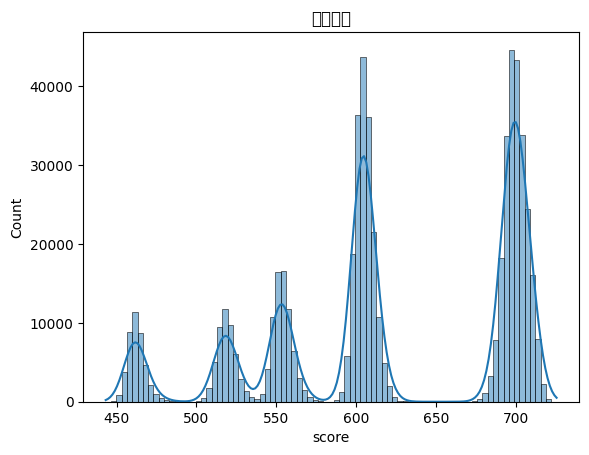

In [283]:
sns.histplot(train['score'], kde=True)
plt.title('数据分布')
plt.show()

c:\Users\谭艺星\OneDrive\桌面\毕业设计\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 36923 (\N{CJK UNIFIED IDEOGRAPH-903B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\谭艺星\OneDrive\桌面\毕业设计\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 36753 (\N{CJK UNIFIED IDEOGRAPH-8F91}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\谭艺星\OneDrive\桌面\毕业设计\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 22238 (\N{CJK UNIFIED IDEOGRAPH-56DE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\谭艺星\OneDrive\桌面\毕业设计\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24402 (\N{CJK UNIFIED IDEOGRAPH-5F52}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\谭艺星\OneDrive\桌面\毕业设计\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20915 (\N{CJK U

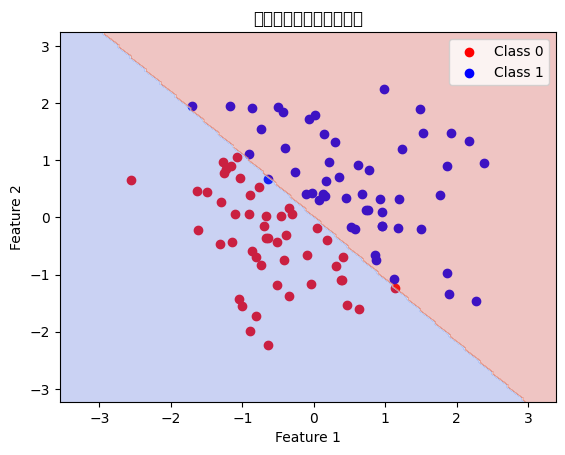

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

# 生成样本数据
np.random.seed(0)
X = np.random.randn(100, 2)
Y = (X[:, 0] + X[:, 1] > 0).astype(int)

# 训练逻辑回归模型
model = LogisticRegression()
model.fit(X, Y)

# 画出数据点
plt.scatter(X[Y==0][:, 0], X[Y==0][:, 1], color='red', label='Class 0')
plt.scatter(X[Y==1][:, 0], X[Y==1][:, 1], color='blue', label='Class 1')

# 绘制决策边界
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# 画出决策边界
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.title('逻辑回归决策边界示意图')
plt.show()